## License
Copyright 2020 (c) Anna Olena Zhab'yak, Michele Maione. All rights reserved.

Licensed under the [MIT](LICENSE) License.

# Dataset

The dataset used in this regression has 10 features and 20639 observations. In more detailes the columns are:

1.	longitude: A measure of how far west a house is
2.	latitude: A measure of how far north a house is
3.	housingMedianAge: Median age of a house within a block
4.	totalRooms: Total number of rooms within a block
5.	totalBedrooms: Total number of bedrooms within a block
6.	population: Total number of people residing within a block
7.	households: Total number of households, a group of people residing within a home unit, for a block
8.	medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9.	medianHouseValue: Median house value for households within a block (measured in US Dollars)
10.	 oceanProximity: Location of the house w.r.t ocean/sea

the dataset is avaible from this website : https://www.dropbox.com/s/zxv6ujxl8kmijfb/cal-housing.csv?dl=0 


---------------------

### Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the Ridge and Lasso regression from scratch, the PCA, the model selection and validation using sklearn. First, let's download the libraries!

In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, cross_validate, train_test_split, KFold, GridSearchCV

from plotting import Plotting
from lasso import Lasso
from lsqr import LSQR
from cholesky import Cholesky
from svd import SVD

---------------------------------------

### Dataset overview

We open the database to check the structure and show the head,and take a look of its descriptive statistics.



In [2]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


---------------------------------

### Data pre-processing 
Before performing the analysis we create the constants and and define the statistical elements of the analysis.

The target value is the `median_house_value` which is predicted based on the features of different houses.

Shuffle the data to reduce the error and to give a normal distribution to the whole dataset. 


In [6]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

Here is the distribution of the values of the target variable `median_house_value`. 
It looks like a normal distribution with a group of outliers on the highest value of the house. 

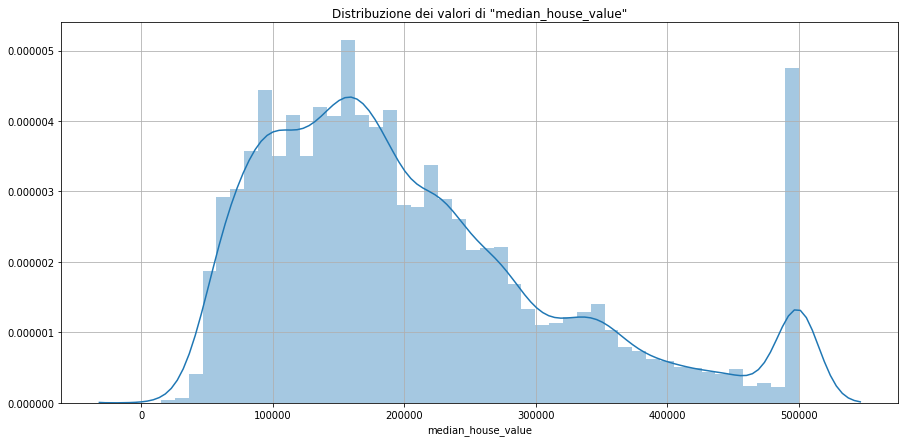

In [7]:
plt.figure(figsize=(15, 7))
plt.title('Distribuzione dei valori di "median_house_value"')
seaborn.distplot(data_frame['median_house_value'])

plt.grid()
plt.show()

We inspect the outliers, and it turns that they represent the 4% of the entire dataset

In [8]:
outliers = data_frame[data_frame[column_to_predict] == 500001].index
print(f'There are {len(outliers)} outliers')
data_frame.drop(outliers, inplace=True)

There are 965 outliers


### Missing values 
The dataset contains missing values which are removed. This procedure is necessary to avoid errors in the execution.

In [9]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

### Scores -  MSE and R²

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [10]:
rscoring = 'r2'
rscoring_neg = False
rscoring_label = 'R²'
rscoring_label_loss = 'R²'

scoring = 'neg_mean_squared_error'
scoring_neg = True
scoring_label = 'MSE'
scoring_label_loss = 'Squared loss'

### Categorical variable
Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers. We create two encoding functions to compare how they qouls work, but at the end we apply the hot encoder of `useColumnCat`, this creates a column for every element of the categorical variable , add them to the rest of the dataset using dummies. 


In [11]:
useLabelEncoder = False
useColumnCat = True

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)
elif useColumnCat:
    # genera le colonne per ogni elemento di una colonna categoria
    columns_categories = pandas.DataFrame()

    for c in categories_columns:
        column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')        
        columns_categories = pandas.concat((columns_categories, column), axis=1)

    for col in columns_categories.columns: 
        numerics_columns.append(col)
        
    # elimina le colonne categoria
    data_frame.drop(columns=categories_columns, inplace=True)

    # aggiungi le colonne per ogni elemento di una colonna categoria
    data_frame = pandas.concat([data_frame, columns_categories], axis=1)
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND', 'NEAR BAY'], [1, 20, 100, 1500, 500], inplace=True)
    numerics_columns.append('ocean_proximity')

In [12]:
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)
#data_frame = data_frame.sample(frac=1)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

Our dataset now looks like this 

In [13]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,0,1,0,0,0


and this is our target variable 

In [14]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 19675, dtype: float64

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 
Pearson's coefficient is determined by :


$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

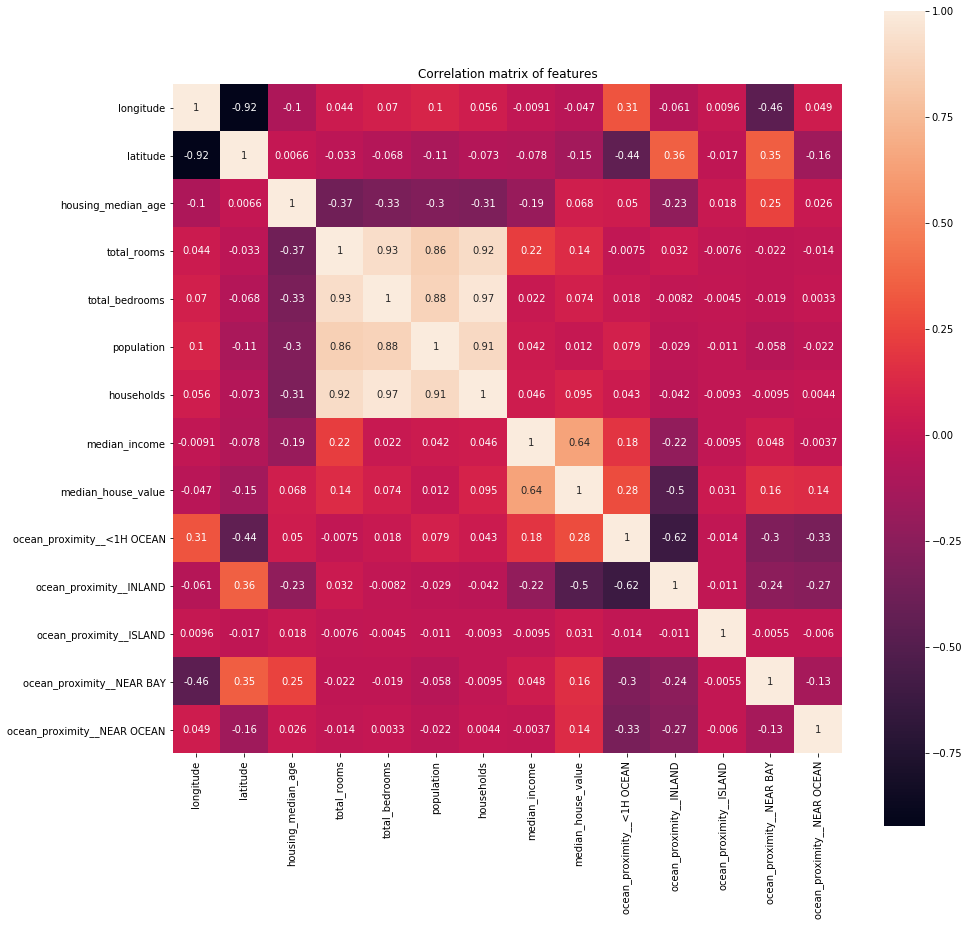

In [15]:
corr = data_frame.corr()

plt.figure(figsize=(15, 15))
plt.title('Correlation matrix of features')

seaborn.heatmap(corr, square=True, annot=True)
plt.show()

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [16]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.930916,0.859590,0.921102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.930916,NaN,0.875270,0.974006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.859590,0.875270,NaN,0.908997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.921102,0.974006,0.908997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can implement furhter on the PCA sicne some features seems to be correlated 

----------------


# Data analysis and modelling

Ones we have cleaned all the data, we can procede with the application of the Ridge and Lasso regression and the PCA. 

## Ridge regression

This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
The mechanism consists in minimizing two elements, the RSS and the objective function tuned by a certain parameter $\alpha $ , so the objective function is: 

$$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $$

The tunning parameter alpha controls the model complexity and the a trade off between variance and bias.

1. How well the model fits our data gives the bias
2. how well model does on a completely new dataset goves the variance 

We use the hyperparameter $ \alpha $ , to add a bias and prevent the model from overfitting.

First of all we split the dataset into train and test set 80% and 20 % respectively 

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1986)

print('Train size:', x_train.shape[0])
print('Test size:', x_test.shape[0])

Train size: 15740
Test size: 3935


We have created three different implementations, but we proceed with the Cholesky decomposition, which is the so-called closed-form solution 

In [18]:
#ridge = LSQR()
#ridge= SVD()
ridge = Cholesky()

The values for the hyperparameter $ \alpha $ are generated as follows, using a logspace

In [19]:
alphas = numpy.sort(numpy.logspace(-5, -0.1, 20))
alphas

array([1.00000000e-05, 1.81090112e-05, 3.27936286e-05, 5.93860187e-05,
       1.07542208e-04, 1.94748304e-04, 3.52669921e-04, 6.38650355e-04,
       1.15653264e-03, 2.09436625e-03, 3.79269019e-03, 6.86818691e-03,
       1.24376073e-02, 2.25232770e-02, 4.07874276e-02, 7.38619982e-02,
       1.33756775e-01, 2.42220294e-01, 4.38637001e-01, 7.94328235e-01])

The validation of this parameter is done 

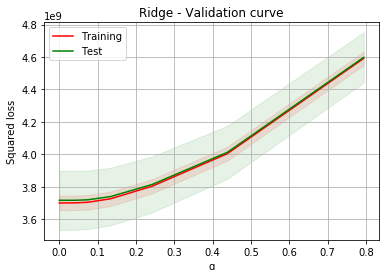

Best ɑ: 0.022523277049873842


In [20]:
train_score, test_scores = validation_curve(ridge, x_train, y_train, param_name="alpha", param_range=alphas, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Ridge - Validation curve',
    alphas,
    [train_score, test_scores],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'ɑ',
    scoring_label_loss)

best_ɑ = alphas[numpy.argmax(test_scores.mean(axis=1))]
ridge.alpha = best_ɑ
print('Best ɑ:', best_ɑ)

More over we use a nested corss validation on the best aplha to see how this value is tunned given individual trial.

In [ ]:
ridge.alphas = alphas
ridge.nestedCrossValidationKFold(x_train, y_train)

In [ ]:
Plotting.plotNestedCrossVal(
    ridge.nested_cross_validation_trials,
    ridge.nested_scores,
    ridge.non_nested_scores,
    ridge.score_difference)

### Learning curve 

Here we train our algorithm using the 5-fold cross-validation on the best estimated hyperparameter by the nested cross-validation.

In [ ]:
min_ts = int(x_train.shape[0] * 0.01)
max_ts = int(x_train.shape[0] * 0.8)
step_ts = int(x_train.shape[0] * 0.1)
sizes = range(min_ts, max_ts, step_ts)

print(sizes)

In [ ]:
train_size, train_score, test_scores = learning_curve(ridge, x_train, y_train, train_sizes=sizes, shuffle=True, random_state=1986, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Ridge - Learning curve',
    train_size,
    [train_score, test_scores],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

## Lasso regression 
this technique is similar to the previous one, but the minimizing objective function becomes:
$$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert $$

Lasso regression give a sparser solutions in general, and it shrinks some coefficients to zero. 